# Web Scraping                                                       

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup as bs
from requests import get
import numpy as np
from bs4 import BeautifulSoup,NavigableString,Tag
import re
import os
import requests

In [ ]:
# Loading the first part of food hacks site
url = "https://food-hacks.wonderhowto.com/how-to/cook-any-cuisine-perfectly-by-knowing-right-ingredients-use-part-1-0168105/"
html_page = requests.get(url).text
html_parser=bs(html_page)

In [ ]:
# Extracting most commenly used ingredients from each cuisine html tag

cusines = []
ingrs = []

for cu in html_parser.find_all('h2')[1:]:
    cusines.append(cu.get_text())
    ul = cu.find_next('ul')
    ingr = []
    for li in ul.find_all('li'):
        ingr.append(li.get_text())
    ingrs.append(ingr)

data = []
for idx, cu in enumerate(cusines):
    for ingr in ingrs[idx]:
        data.append([cu, ingr])

df = pd.DataFrame(data, columns=['cuisine', 'ingredient'])

In [ ]:
# Loading the second part of food hacks site
url_2 = "https://food-hacks.wonderhowto.com/how-to/cook-any-cuisine-perfectly-by-knowing-right-ingredients-use-part-2-0168253/"
html_page_2 = requests.get(url_2).text
html_parser_2=bs(html_page_2)

In [ ]:
# Extracting most commenly used ingredients from each cuisine html tag
cusines = []
ingrs = []

for cu in html_parser_2.find_all('h2')[1:]:
    cusines.append(cu.get_text())
    if cu.get_text=='Thai':
        ul=cu.find_next_sibling('ul')
    else:
        ul = cu.find_next('ul')
    ingr = []
    for li in ul.find_all('li'):
        ingr.append(li.get_text())
    ingrs.append(ingr)

data = []
for idx, cu in enumerate(cusines):
    for ingr in ingrs[idx]:
        data.append([cu, ingr])

df2 = pd.DataFrame(data, columns=['cuisine', 'ingredient'])

In [ ]:
# merging extracted data from two sites
cusine_2=df2
final_cusine=pd.concat([cusine_1_df,cusine_2])

# Cuisine segmentation 

In [16]:
import pandas as pd

In [30]:
# data injetion
cuisine_df = pd.read_excel("data/cusine.xlsx")
aisles_df = pd.read_csv("data/aisles.csv")
departments_df = pd.read_csv("data/departments.csv")
order_products__prior_df = pd.read_csv("data/order_products__prior.csv")
order_products__train_df = pd.read_csv("data/order_products__train.csv")
orders_df = pd.read_csv("data/orders.csv")
products_df = pd.read_csv("data/products.csv")
sample_submission_df = pd.read_csv("data/sample_submission.csv")

In [18]:
# Filtering products dataframe to remove non-edible products.
products_df = products_df[products_df["aisle_id"].isin([2,4,5,7,9,12,13,14,16,21,30,38,42,59,63,65,66,67,68,76,79,81,104,110,122,128,131])]
req_prod_ids = products_df["product_id"]
order_products__prior_df = order_products__prior_df[order_products__prior_df["product_id"].isin(req_prod_ids)]
order_products__prior_df = order_products__prior_df.merge(products_df[["product_id", "product_name"]],on="product_id",how="inner")

In [19]:
# Extracting order counts for the filtered products
prior_order_prods = order_products__prior_df.groupby('order_id')['product_name'].apply(list).to_frame().reset_index()
prior_order_df = prior_order_prods.merge(orders_df,on="order_id",how="inner")
prior_orders = prior_order_df.groupby('user_id')['product_name'].apply(list).to_frame().reset_index()
prior_orders = prior_orders.rename(columns={"product_name": "orders"})

In [31]:
# preprocessing cuisine labels
cuisine_df = cuisine_df.groupby('cuisine')['ingredient'].apply(list).transform(lambda x: ','.join(x)).reset_index()
cuisine_df = [x+": "+y for x,y in zip(cuisine_df["cuisine"],cuisine_df["ingredient"])]

In [35]:
cuisine_df

['Amercian: Barbecue sauce,tomato paste,Steak,Broccoli,Lettuce,Kale,turkey,bagel,brioche,Hot Dogs,sandwich bread,mayonnaise,pumpkin,Apple cider vinegar,Cornmeal,Sweet corn,Potato chips,Hot sauce,garlic powder,onion powder,Maple syrup,Cajun seasoning,Rotisserie Chicken,Sweet potatoes,Peanut butter,ketchup,burger,Bacon,Sausage,Hot dog,Red beans,Buttermilk,Worcestershire sauce,Old Bay seasoning,spinach,string cheese,Kraft american cheese',
 'Chinese: five-spice powder, Szechuan peppercorns, star anise, hoisin sauce, oyster sauce,mustard seed, kaffir lime leaf, anise, cilantro, ginger, red chilies, peppers, taro root, lotus root, kumquats, orange/tangerine, Chinese broccoli (aka Chinese kale), bok choy, pea pods,Tofu,Rice, noodles, dumplings ,Duck',
 'French: cloves, nutmeg, saffron,chervil, dill, tarragon, dried rosemary, thyme, bay leaf, savory,duck,endive, shallots, fennel, lentils, zucchini, eggplant,pears, plums, apples,Bread, croissants, pastries, potatoes,duck',
 'Greek: allspice, c

# Assymetric semantic search

In [ ]:
import torch
import re
from sentence_transformers import SentenceTransformer, CrossEncoder,util

In [ ]:
# tested with both bi-encoder and cross encoders, performance cross encoder is much better than bi-encoder. Below code is for bi-encoder
sbert_model = SentenceTransformer("sentence-transformers/msmarco-distilbert-cos-v5")
for i in range(0,5):
    for order in prior_orders["orders"][i]:
        for product in order:
            
            order_embedding = sbert_model.encode(re.sub(r'[^A-Za-z ]+', '', product), convert_to_tensor=True)
            scores = util.cos_sim(order_embedding, cuisine_embeddings)[0]
            matched_cuisines = torch.topk(scores, k=1)

            print("\n\n======================\n\n")
            print("Query:", re.sub(r'[^A-Za-z ]+', '', product))
            print("\nSimilar cuisines:")

            for score, idx in zip(matched_cuisines[0], matched_cuisines[1]):
                print(cuisine_df[idx], "(Score: {:.4f})".format(score))

In [ ]:
# loading cross encoder model from sentese transfomers
from sentence_transformers import CrossEncoder
model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-12-v2", max_length=512)

In [ ]:
# classfied prodects into cuisines
product_cuisine_map = []
for product in tqdm(list(products_df["product_name"])):
    scores = model.predict([(re.sub(r'[^A-Za-z ]+', '', product), cuisine) for cuisine in cuisine_df])
    cuisine = np.argmax(scores)
    product_cuisine_map.append(cuisine)

In [ ]:
# saving the product_cuisine_map for further inference
products_df["cuisine"] = product_cuisine_map
products_df.to_csv("product_cusine_df.csv")

In [39]:
# Extracting cuisine names from cuisine labels
cuisines = [i[:i.find(":")] for i in cuisine_df]

In [ ]:
products_df = pd.read_csv("product_cusine_df.csv")

In [38]:
products_df

,Unnamed: 0,product_id,product_name,aisle_id,department_id,cuisine
0,17,18,Pizza for One Suprema Frozen Pizza,79,1,Italian
1,18,19,Gluten Free Quinoa Three Cheese & Mushroom Blend,63,9,Italian
2,28,29,Fresh Cut Golden Sweet No Salt Added Whole Ker...,81,15,Amercian
3,29,30,"Three Cheese Ziti, Marinara with Meatballs",38,1,Italian
4,32,33,Organic Spaghetti Style Pasta,131,9,Italian
...,...,...,...,...,...,...
9509,49657,49658,Brie with Herbs Foil Wedge,2,16,French
9510,49666,49667,Enchilada with Spanish Rice & Beans Meal,38,1,Mexican
9511,49676,49677,Thick & Chunky Sloppy Joe Sauce,59,15,Amercian
9512,49680,49681,Spaghetti with Meatballs and Sauce Meal,38,1,Italian


In [41]:
# Filtering the daata for order counts to create visualizations
order_products__prior_df = pd.read_csv("data/order_products__prior.csv")
orders_df = pd.read_csv("data/orders.csv")
req_prod_ids = products_df["product_id"]
order_products__prior_df = order_products__prior_df[order_products__prior_df["product_id"].isin(req_prod_ids)]
order_products__prior_df = order_products__prior_df.merge(products_df[["product_id", "cuisine"]],on="product_id",how="inner")
cuisine_orders = order_products__prior_df["cuisine"].value_counts().to_frame().reset_index()

In [43]:
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import squarify

In [44]:
# Adding custom legend to square plot
labels = [Patch(facecolor="#FFFFFF",label = str(x)+" - "+str(y)) for x,y in zip(cuisine_orders["index"],cuisine_orders["cuisine"])]

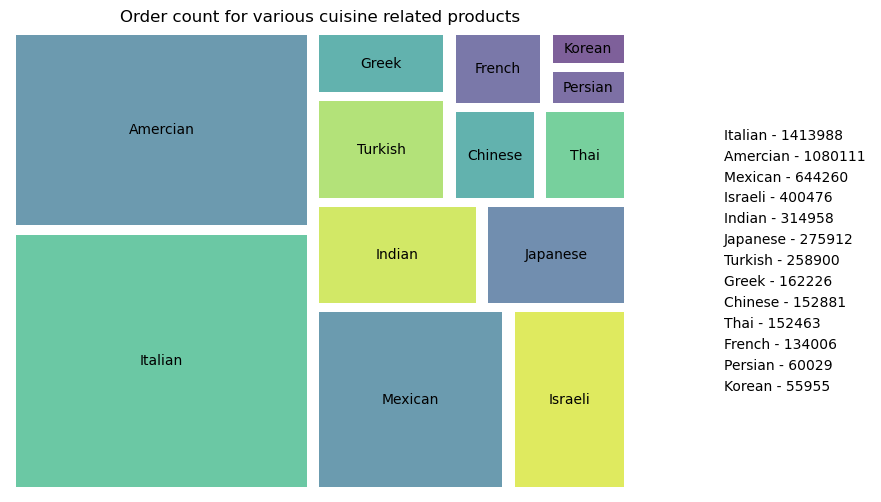

In [45]:
# plot depicting order counts of various cuisine related products
plt.figure(figsize=(8, 6))
plt.title("Order count for various cuisine related products")
plt.axis('off')
squarify.plot(sizes=cuisine_orders["cuisine"], label=cuisine_orders["index"], alpha=.7,pad=2)
plt.legend(handles=labels,loc='center right',bbox_to_anchor=(1.4, 0.5),frameon=False)
plt.show()